<a href="https://colab.research.google.com/github/Ahmad162539/ML-class-excercise-codes/blob/main/ESMFold_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ **IMPORTANT**!!
# ✅ **The root path is ./content!!**

# ⏭ Install dependencies

In [1]:
%%time

import os, time
if not os.path.isfile("esmfold.model"):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

  # install libs
  os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol")
  os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

  # install openfold
  commit = "6908936b68ae89f67755240e2f588c09ec31d4c8"
  os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

  # install esmfold
  os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")

  # wait for Params to finish downloading...
  if not os.path.isfile("esmfold.model"):
    # backup source!
    os.system("aria2c -q -x 16 https://files.ipd.uw.edu/pub/esmfold/esmfold.model")
  else:
    while os.path.isfile("esmfold.model.aria2"):
      time.sleep(5)

CPU times: user 700 ms, sys: 110 ms, total: 810 ms
Wall time: 3min 23s


# ⏭ Get Target data

## Provide target data (Glucokinase, *glk*, b2388)

In [2]:
!wget https://rest.uniprot.org/uniprotkb/P0A6V8.fasta

--2023-05-31 07:23:43--  https://rest.uniprot.org/uniprotkb/P0A6V8.fasta
Resolving rest.uniprot.org (rest.uniprot.org)... 193.62.193.81
Connecting to rest.uniprot.org (rest.uniprot.org)|193.62.193.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419 [text/plain]
Saving to: ‘P0A6V8.fasta’

P0A6V8.fasta        100%[===================>]     419  --.-KB/s    in 0s      

2023-05-31 07:23:44 (86.9 MB/s) - ‘P0A6V8.fasta’ saved [419/419]



In [3]:
from Bio import SeqIO
target = SeqIO.read("P0A6V8.fasta", "fasta")
query_sequence = str(target.seq)
jobname = "P0A6V8"
print(f"Its sequence is ...{jobname}")
print(f"Its sequence length is ...{len(query_sequence)}")

Its sequence is ...P0A6V8
Its sequence length is ...321


## Custom data (Upload to drive)

In [ ]:
# from Bio import SeqIO
# fasta_path = "" # Specify the uploaded target fasta path
# target = SeqIO.read(fasta_path, "fasta")
# query_sequence = str(target.seq)
# jobname = ""
# print(f"Its sequence is ...{jobname}")
# print(f"Its sequence length is ...{len(query_sequence)}")

# ⏭ Run Prediction

In [4]:
import torch

model = torch.load("esmfold.model")
model = model.eval().cuda()

output = model.infer_pdb(query_sequence)

output_path = jobname + "_esmfold.pdb"

with open(output_path, "w") as f:
    f.write(output)
    f.close()

# ⏭ Display 3D structure

## Ribbon Visualization

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

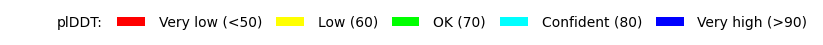

In [6]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 # ["1", "2", "3", "4", "5"]
color = "lDDT" # ["chain", "lDDT", "rainbow"]

def show_ribbon_pdb(rank_num=1, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')
  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  view.zoomTo()
  return view

def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

pdb_file = glob.glob(output_path)

show_ribbon_pdb(rank_num, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

## Surface Visualization

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

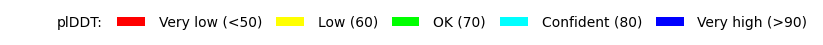

In [7]:
import py3Dmol
import glob
import matplotlib.pyplot as plt

rank_num = 1 # ["1", "2", "3", "4", "5"]
color = "lDDT" # ["white", "lDDT", "rainbow"]

def show_surface_pdb(rank_num=1, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.addSurface(py3Dmol.VDW,{"colorscheme": {'prop':'b','gradient': 'roygb','min':50,'max':90}})
  elif color == "rainbow":
    view.addSurface(py3Dmol.VDW,{"color": "spectrum"})
  elif color == "white":
    view.addSurface(py3Dmol.VDW,{"color": "white"})

  view.zoomTo()
  return view

def plot_plddt_legend(dpi=100):
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=dpi)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

pdb_file = glob.glob(output_path)

show_surface_pdb(rank_num, color).show()
if color == "lDDT":
  plot_plddt_legend().show()